In [1]:
# Imports (for Graphs + Analysis)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tabulate import tabulate

sns.set_theme(style='ticks', context='paper')

In [2]:
# Constants
ENERGY_CONSUMPTION = "Energy Consumption (exc. PUE)"
ENERGY_CONSUMPTION_PUE = "Energy Consumption (inc. PUE)"
MEMORY_CONSUMPTION = "Memory Energy Consumption (exc. PUE)"
MEMORY_CONSUMPTION_PUE = "Memory Energy Consumption (inc. PUE)"
CARBON_EMISSIONS = "Carbon Emissions"

In [7]:
# Trace File Paths List
workflows = ['chipseq', 'mag', 'montage', 'nanoseq', 'rangeland', 'rnaseq', 'sarek']
regions = ['Great Britain', 'Germany', 'California', 'Texas', 'South Africa', 'Tokyo', 'New South Wales']
short_regions = ['gb', 'de', 'ca', 'tx', 'zaf', 'tyo', 'nsw']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
short_months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] 
month_dates = ['08012024-13012024', '12022024-17022024', '11032024-16032024',  
    '08042024-13042024', '13052024-18052024', '10062024-15062024',  
    '08072024-13072024', '12082024-17082024', '09092024-14092024',  
    '14102024-19102024', '11112024-16112024', '09122024-14122024']
region_folders = [f'../data/results/interrupt-wf-shifting/out/{region}/' for region in short_regions]

In [26]:
def get_max_overhead(overheads):
    oh_1, _ = overheads[0].split('|')
    oh_2, _ = overheads[1].split('|')
    oh_3, _ = overheads[2].split('|')

    return max([float(oh_1), float(oh_2), float(oh_3)])
    

def parse_ts_summary_file(file):
    with open(file, 'r') as f:
        lines = f.readlines()[1:]

    props = {}

    for line in lines:
        parts = line.split(',')
        workflow = parts[0].split('-')[0]
        footprint = float(parts[1])
        makespan = float(parts[2])
        entry_6h = parts[3].split(':')
        entry_12h = parts[4].split(':')
        entry_24h = parts[5].split(':')
        entry_48h = parts[6].split(':')
        entry_96h = parts[7].split(':')

        if len(props) == 0:
            props = {
                "FOOTPRINT": [footprint],
                "MAKESPAN": [makespan],
                "6H_FOOTPRINT": [float(entry_6h[1])],
                "6H_REDUCTION": [float(entry_6h[0][:-1])],
                "6H_OVERHEAD": [entry_6h[2]],
                "12H_FOOTPRINT": [float(entry_12h[1])],
                "12H_REDUCTION": [float(entry_12h[0][:-1])],
                "12H_OVERHEAD": [entry_12h[2]],
                "24H_FOOTPRINT": [float(entry_24h[1])],
                "24H_REDUCTION": [float(entry_24h[0][:-1])],
                "24H_OVERHEAD": [entry_24h[2]],
                "48H_FOOTPRINT": [float(entry_48h[1])],
                "48H_REDUCTION": [float(entry_48h[0][:-1])],
                "48H_OVERHEAD": [entry_48h[2]],
                "96H_FOOTPRINT": [float(entry_96h[1])],
                "96H_REDUCTION": [float(entry_96h[0][:-1])],
                "96H_OVERHEAD": [entry_96h[2]]
            }
        else: 
            props["FOOTPRINT"].append(footprint)
            props["MAKESPAN"].append(makespan)
            props["6H_FOOTPRINT"].append(float(entry_6h[1]))
            props["6H_REDUCTION"].append(float(entry_6h[0][:-1]))
            props["6H_OVERHEAD"].append(entry_6h[2])
            props["12H_FOOTPRINT"].append(float(entry_12h[1]))
            props["12H_REDUCTION"].append(float(entry_12h[0][:-1]))
            props["12H_OVERHEAD"].append(entry_12h[2])
            props["24H_FOOTPRINT"].append(float(entry_24h[1]))
            props["24H_REDUCTION"].append(float(entry_24h[0][:-1]))
            props["24H_OVERHEAD"].append(entry_24h[2])
            props["48H_FOOTPRINT"].append(float(entry_48h[1]))
            props["48H_REDUCTION"].append(float(entry_48h[0][:-1]))
            props["48H_OVERHEAD"].append(entry_48h[2])
            props["96H_FOOTPRINT"].append(float(entry_96h[1]))
            props["96H_REDUCTION"].append(float(entry_96h[0][:-1]))
            props["96H_OVERHEAD"].append(entry_96h[2])

    data = {}
    wf_makespan = sum(props["MAKESPAN"]) / 3
    footprint_6h = sum(props["6H_FOOTPRINT"]) / 3
    reduction_6h = sum(props["6H_REDUCTION"]) / 3
    max_overhead_6h = get_max_overhead(props["6H_OVERHEAD"])
    footprint_12h = sum(props["12H_FOOTPRINT"]) / 3
    reduction_12h = sum(props["12H_REDUCTION"]) / 3

    if reduction_12h < reduction_6h:
        reduction_12h = reduction_6h

    max_overhead_12h = get_max_overhead(props["12H_OVERHEAD"])
    footprint_24h = sum(props["24H_FOOTPRINT"]) / 3
    reduction_24h = sum(props["24H_REDUCTION"]) / 3

    if reduction_24h < reduction_12h:
        reduction_24h = reduction_12h

    max_overhead_24h = get_max_overhead(props["24H_OVERHEAD"])
    footprint_48h = sum(props["48H_FOOTPRINT"]) / 3
    reduction_48h = sum(props["48H_REDUCTION"]) / 3

    if reduction_48h < reduction_24h:
        reduction_48h = reduction_24h

    max_overhead_48h = get_max_overhead(props["48H_OVERHEAD"])
    footprint_96h = sum(props["96H_FOOTPRINT"]) / 3
    reduction_96h = sum(props["96H_REDUCTION"]) / 3

    if reduction_96h < reduction_48h:
        reduction_96h = reduction_48h

    max_overhead_96h = get_max_overhead(props["6H_OVERHEAD"])

    data = {
        "FOOTPRINT": sum(props["FOOTPRINT"]) / 3,
        "MAKESPAN": wf_makespan,
        "6H_REDUCTION": reduction_6h,
        "6H_OVERHEAD":  max_overhead_6h,
        "12H_REDUCTION":  reduction_12h,
        "12H_OVERHEAD":  max_overhead_12h,
        "24H_REDUCTION":  reduction_24h,
        "24H_OVERHEAD":  max_overhead_24h,
        "48H_REDUCTION":  reduction_48h,
        "48H_OVERHEAD":  max_overhead_48h,
        "96H_REDUCTION":  reduction_96h,
        "96H_OVERHEAD":  max_overhead_96h
    }

    return data
        

In [31]:
# Interrupting Footprints - Average CI
headers = ["Workflow", "Original Footprint (gCO2e)", "Makespan (s)", "Reduction 12h (%)", "Overhead", "Reduction 24h (%)", "Overhead", "Reduction 48h (%)", "Overhead", "Reduction 96h (%)", "Overhead", "Reduction 192h (%)","Overhead"]
data = []

for region, region_base in zip(short_regions, region_folders):
    for month in short_months:
        for workflow in workflows:
            temp = parse_ts_summary_file(f'{region_base}{workflow}-{month}-avg-ts.csv')
            data.append([f'{workflow}-{month}',f'{temp["FOOTPRINT"]:.2f}', f'{temp["MAKESPAN"]:.0f}', 
                 f"{temp['6H_REDUCTION']:.2f}", f"{temp['6H_OVERHEAD']:.2f}", 
                 f"{temp['12H_REDUCTION']:.2f}", f"{temp['12H_OVERHEAD']:.2f}", 
                 f"{temp['24H_REDUCTION']:.2f}", f"{temp['24H_OVERHEAD']:.2f}",
                 f"{temp['48H_REDUCTION']:.2f}", f"{temp['48H_OVERHEAD']:.2f}",
                 f"{temp['96H_REDUCTION']:.2f}", f"{temp['96H_OVERHEAD']:.2f}"])
print("Temporal Workflow Shifting Reduction Potential - Average")
print(tabulate(data, headers, tablefmt='orgtbl'))

Temporal Workflow Shifting Reduction Potential - Average
| Workflow      |   Original Footprint (gCO2e) |   Makespan (s) |   Reduction 12h (%) |   Overhead |   Reduction 24h (%) |   Overhead |   Reduction 48h (%) |   Overhead |   Reduction 96h (%) |   Overhead |   Reduction 192h (%) |   Overhead |
|---------------+------------------------------+----------------+---------------------+------------+---------------------+------------+---------------------+------------+---------------------+------------+----------------------+------------|
| chipseq-jan   |                      4763.62 |          13324 |               20.83 |    1412.47 |               27.13 |    1412.47 |               27.3  |    2165.28 |               34.07 |       0    |                50.03 |    1412.47 |
| mag-jan       |                      6738.38 |          45476 |               17.97 |    6721.99 |               23.43 |    3574.76 |               24.63 |    3560.99 |               28.9  |    3800.99 |            

In [ ]:
# Interrupting Footprints - Marginal CI
headers = ["Workflow", "Original Footprint (gCO2e)", "Makespan (s)", "Reduction 12h (%)", "Overhead", "Reduction 24h (%)", "Overhead", "Reduction 48h (%)", "Overhead", "Reduction 96h (%)", "Overhead", "Reduction 192h (%)","Overhead"]
data = []

for region, region_base in zip(short_regions, region_folders):
    for month in short_months:
        for workflow in workflows:
            temp = parse_ts_summary_file(f'{region_base}{workflow}-{month}-marg-ts.csv')
            data.append([f'{workflow}-{month}',f'{temp["FOOTPRINT"]:.2f}', f'{temp["MAKESPAN"]:.0f}', 
                 f"{temp['6H_REDUCTION']:.2f}", f"{temp['6H_OVERHEAD']:.2f}", 
                 f"{temp['12H_REDUCTION']:.2f}", f"{temp['12H_OVERHEAD']:.2f}", 
                 f"{temp['24H_REDUCTION']:.2f}", f"{temp['24H_OVERHEAD']:.2f}",
                 f"{temp['48H_REDUCTION']:.2f}", f"{temp['48H_OVERHEAD']:.2f}",
                 f"{temp['96H_REDUCTION']:.2f}", f"{temp['96H_OVERHEAD']:.2f}"])
print("Temporal Workflow Shifting Reduction Potential - Marginal")
print(tabulate(data, headers, tablefmt='orgtbl'))

Temporal Workflow Shifting Reduction Potential - Marginal
| Workflow      |   Original Footprint (gCO2e) |   Makespan (s) |   Reduction 12h (%) |   Overhead |   Reduction 24h (%) |   Overhead |   Reduction 48h (%) |   Overhead |   Reduction 96h (%) |   Overhead |   Reduction 192h (%) |   Overhead |
|---------------+------------------------------+----------------+---------------------+------------+---------------------+------------+---------------------+------------+---------------------+------------+----------------------+------------|
| chipseq-jan   |                     11776.5  |          13324 |                1.1  |    1142.56 |                2.7  |     877.41 |                5.6  |     589.94 |                9.7  |    1665.83 |                15.4  |    1142.56 |
| mag-jan       |                     15495.5  |          45476 |                0.53 |     856.63 |                1.43 |    1114.81 |                2.8  |     496.49 |                6.33 |     829.81 |           

** old code **

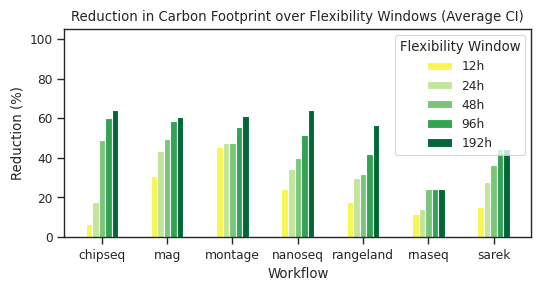

In [ ]:
# Draw Graph Comparing Reductions

groups = len(workflows)
ind = np.arange(groups)  # x locs for each workflow group
width = 0.1  # width of each bar

fig = plt.figure(figsize=(5.5,3))
ax = fig.add_subplot()

red_12h_grp = [] 
red_24h_grp = []
red_48h_grp = []
red_96h_grp = []
red_192h_grp = []
results_avg = parse_ts_summary_file('data/temporal-shifting/avg/workflows-ts.csv')

for workflow in workflows:
    # f'{float(results_avg[workflow]["FOOTPRINT"]):.2f}'
    red_6h = results_avg[workflow]['6H_REDUCTION']
    red_12h_grp.append(red_6h)
    red_12h = results_avg[workflow]['12H_REDUCTION']
    red_24h_grp.append(red_12h)
    red_24h = results_avg[workflow]['24H_REDUCTION']
    red_48h_grp.append(red_24h)
    red_48h = results_avg[workflow]['48H_REDUCTION']
    red_96h_grp.append(red_48h)
    red_96h = results_avg[workflow]['96H_REDUCTION']
    red_192h_grp.append(red_96h)
    
g1 = ax.bar(ind - width, red_12h_grp, width, color='#f7f74f')
g2 = ax.bar(ind, red_24h_grp, width, color='#c2e699')
g3 = ax.bar(ind + width, red_48h_grp, width, color='#78c679')
g4 = ax.bar(ind + (width * 2), red_96h_grp, width, color='#31a354')
g5 = ax.bar(ind + (width * 3), red_192h_grp, width, color='#006837')

ax.set_xticks(ind+width)
ax.set_xticklabels(workflows)
ax.legend((g1, g2, g3, g4, g5), ('12h', '24h', '48h', '96h', '192h'), title='Flexibility Window', loc='upper right')
ax.set_ylim(0,105)
ax.set_xlabel('Workflow')
ax.set_ylabel('Reduction (%)')
ax.set_title('Reduction in Carbon Footprint over Flexibility Windows (Average CI)')

plt.tight_layout()
plt.savefig('image/cf-reduction-interrupt-flex-avg.pdf', dpi=300, bbox_inches='tight')
plt.show()


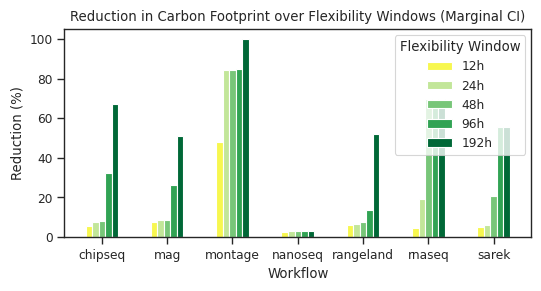

In [ ]:
# Draw Graph Comparing Reductions

groups = len(workflows)
ind = np.arange(groups)  # x locs for each workflow group
width = 0.1  # width of each bar

fig = plt.figure(figsize=(5.5,3))
ax = fig.add_subplot()

red_12h_grp = [] 
red_24h_grp = []
red_48h_grp = []
red_96h_grp = []
red_192h_grp = []
results_marg = parse_ts_summary_file('data/temporal-shifting/marg/workflows-ts.csv')

for workflow in workflows:
    # f'{float(results_avg[workflow]["FOOTPRINT"]):.2f}'
    red_6h = results_marg[workflow]['6H_REDUCTION']
    red_12h_grp.append(red_6h)
    red_12h = results_marg[workflow]['12H_REDUCTION']
    red_24h_grp.append(red_12h)
    red_24h = results_marg[workflow]['24H_REDUCTION']
    red_48h_grp.append(red_24h)
    red_48h = results_marg[workflow]['48H_REDUCTION']
    red_96h_grp.append(red_48h)
    red_96h = results_marg[workflow]['96H_REDUCTION']
    red_192h_grp.append(red_96h)
    
g1 = ax.bar(ind - width, red_12h_grp, width, color='#f7f74f')
g2 = ax.bar(ind, red_24h_grp, width, color='#c2e699')
g3 = ax.bar(ind + width, red_48h_grp, width, color='#78c679')
g4 = ax.bar(ind + (width * 2), red_96h_grp, width, color='#31a354')
g5 = ax.bar(ind + (width * 3), red_192h_grp, width, color='#006837')

ax.set_xticks(ind+width)
ax.set_xticklabels(workflows)
ax.legend((g1, g2, g3, g4, g5), ('12h', '24h', '48h', '96h', '192h'), title='Flexibility Window', loc='upper right')
ax.set_ylim(0, 105)
ax.set_xlabel('Workflow')
ax.set_ylabel('Reduction (%)')
ax.set_title('Reduction in Carbon Footprint over Flexibility Windows (Marginal CI)')

plt.tight_layout()
plt.savefig('image/cf-reduction-interrupt-flex-marg.pdf', dpi=300, bbox_inches='tight')
plt.show()

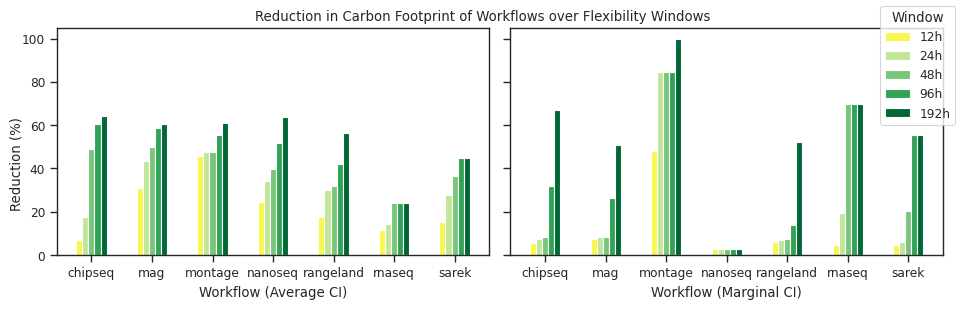

In [ ]:
# Draw Graph Comparing Reductions

groups = len(workflows)
ind = np.arange(groups)  # x locs for each workflow group
width = 0.1  # width of each bar

fig, axs = plt.subplots(1, 2, figsize=(9.5, 3), sharey=True)

red_12h_grp = [] 
red_24h_grp = []
red_48h_grp = []
red_96h_grp = []
red_192h_grp = []
results_avg = parse_ts_summary_file('data/temporal-shifting/avg/workflows-ts.csv')

# PLOT AVERAGE
for workflow in workflows:
    # f'{float(results_avg[workflow]["FOOTPRINT"]):.2f}'
    red_6h = results_avg[workflow]['6H_REDUCTION']
    red_12h_grp.append(red_6h)
    red_12h = results_avg[workflow]['12H_REDUCTION']
    red_24h_grp.append(red_12h)
    red_24h = results_avg[workflow]['24H_REDUCTION']
    red_48h_grp.append(red_24h)
    red_48h = results_avg[workflow]['48H_REDUCTION']
    red_96h_grp.append(red_48h)
    red_96h = results_avg[workflow]['96H_REDUCTION']
    red_192h_grp.append(red_96h)
    
g1 = axs[0].bar(ind - width, red_12h_grp, width, color='#f7f74f')
g2 = axs[0].bar(ind, red_24h_grp, width, color='#c2e699')
g3 = axs[0].bar(ind + width, red_48h_grp, width, color='#78c679')
g4 = axs[0].bar(ind + (width * 2), red_96h_grp, width, color='#31a354')
g5 = axs[0].bar(ind + (width * 3), red_192h_grp, width, color='#006837')

# PLOT MARGINAL
results_marg = parse_ts_summary_file('data/temporal-shifting/marg/workflows-ts.csv')
red_12h_grp = [] 
red_24h_grp = []
red_48h_grp = []
red_96h_grp = []
red_192h_grp = []

for workflow in workflows:
    # f'{float(results_avg[workflow]["FOOTPRINT"]):.2f}'
    red_6h = results_marg[workflow]['6H_REDUCTION']
    red_12h_grp.append(red_6h)
    red_12h = results_marg[workflow]['12H_REDUCTION']
    red_24h_grp.append(red_12h)
    red_24h = results_marg[workflow]['24H_REDUCTION']
    red_48h_grp.append(red_24h)
    red_48h = results_marg[workflow]['48H_REDUCTION']
    red_96h_grp.append(red_48h)
    red_96h = results_marg[workflow]['96H_REDUCTION']
    red_192h_grp.append(red_96h)

g1 = axs[1].bar(ind - width, red_12h_grp, width, color='#f7f74f')
g2 = axs[1].bar(ind, red_24h_grp, width, color='#c2e699')
g3 = axs[1].bar(ind + width, red_48h_grp, width, color='#78c679')
g4 = axs[1].bar(ind + (width * 2), red_96h_grp, width, color='#31a354')
g5 = axs[1].bar(ind + (width * 3), red_192h_grp, width, color='#006837')

axs[0].set_xticks(ind+width)
axs[0].set_xticklabels(workflows)
axs[1].set_xticks(ind+width)
axs[1].set_xticklabels(workflows)
fig.legend((g1, g2, g3, g4, g5), ('12h', '24h', '48h', '96h', '192h'), title='Window', loc='upper right')
# fig.suptitle('Reduction in Workflow Carbon Footprint over Flexibility Windows')
fig.text(0.01, 0.5, 'Reduction (%)', ha='center', va='center', rotation='vertical')
axs[0].set_xlabel('Workflow (Average CI)')
axs[1].set_xlabel('Workflow (Marginal CI)')
fig.text(0.5, 0.99, 'Reduction in Carbon Footprint of Workflows over Flexibility Windows', ha='center', va='center')

plt.tight_layout()
plt.savefig('image/combined-cf-reduction-interrupt-flex.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Combined Table of Both Windows -- MARGINAL CI 
data = []
headers = ["Workflow", "Original Footprint (gCO2e)", "Reduction in 48h (%)", "Reduction in 192h (%)"]
for workflow, base_folder, ci_interval in zip(workflows, workflows_marg_folders, ci_intervals):
    (data_1, min_shift_1, min_emissions_1) = overview(f'{base_folder}explorer-48h/explorer-{workflow}-1-{ci_interval}-marg~footprint.csv')
    (data_2, min_shift_2, min_emissions_2) = overview(f'{base_folder}explorer-48h/explorer-{workflow}-2-{ci_interval}-marg~footprint.csv')
    (data_3, min_shift_3, min_emissions_3) = overview(f'{base_folder}explorer-48h/explorer-{workflow}-3-{ci_interval}-marg~footprint.csv')
    avg_orig_ems_48h = average(data_1[0]['emissions'], data_2[0]['emissions'], data_3[0]['emissions'])
    avg_min_ems_48h = average(min_emissions_1, min_emissions_2, min_emissions_3)
    avg_reduction_48h = get_reduction(avg_orig_ems_48h, avg_min_ems_48h)
    (data_1, min_shift_1, min_emissions_1) = overview(f'{base_folder}explorer-192h/explorer-{workflow}-1-{ci_interval}-marg~footprint.csv')
    (data_2, min_shift_2, min_emissions_2) = overview(f'{base_folder}explorer-192h/explorer-{workflow}-2-{ci_interval}-marg~footprint.csv')
    (data_3, min_shift_3, min_emissions_3) = overview(f'{base_folder}explorer-192h/explorer-{workflow}-3-{ci_interval}-marg~footprint.csv')
    avg_orig_ems_192h = average(data_1[0]['emissions'], data_2[0]['emissions'], data_3[0]['emissions'])
    avg_min_ems_192h = average(min_emissions_1, min_emissions_2, min_emissions_3)
    avg_reduction_192h = get_reduction(avg_orig_ems_192h, avg_min_ems_192h)
    data.append([workflow, float(f"{avg_orig_ems_48h:.2f}"), float(f"{avg_reduction_48h:.2f}"), float(f"{avg_reduction_192h:.2f}")])
print("Entire Workflow Shifting Reduction Potential over 48h + 192h -- MARGINAL")
print(tabulate(data, headers, tablefmt='orgtbl'))
write_data_to_file('ts-whole-marg-both-windows', headers, data)

Entire Workflow Shifting Reduction Potential over 48h + 192h -- MARGINAL
| Workflow   |   Original Footprint (gCO2e) |   Reduction in 48h (%) |   Reduction in 192h (%) |
|------------+------------------------------+------------------------+-------------------------|
| chipseq    |                     27615.4  |                   5.94 |                   66.21 |
| mag        |                     38983.8  |                   6.88 |                   19.9  |
| montage    |                       791    |                  70.83 |                   98.87 |
| nanoseq    |                       232.36 |                   2.75 |                    2.78 |
| rangeland  |                     10075    |                   5.89 |                    7.67 |
| rnaseq     |                     16865.3  |                  70.52 |                   70.52 |
| sarek      |                     51850.1  |                  19.47 |                   60.88 |


In [ ]:
# Interrupting Footprints - Marginal CI
headers = ["Workflow", "Original Footprint (gCO2e)", "Reduction 12h (%)", "Overhead", "Reduction 24h (%)", "Overhead", "Reduction 48h (%)", "Overhead", "Reduction 96h (%)", "Overhead", "Reduction 192h (%)","Overhead"]
results_avg = parse_ts_summary_file('data/temporal-shifting/marg/workflows-ts.csv')
data = []
for workflow in workflows:
    data.append([workflow, 
                 f'{float(results_avg[workflow]["FOOTPRINT"]):.2f}', 
                 f"{results_avg[workflow]['6H_REDUCTION']:.2f}", 
                f"{results_avg[workflow]['6H_OVERHEAD']:.2f}",
                 f"{results_avg[workflow]['12H_REDUCTION']:.2f}", 
                f"{results_avg[workflow]['12H_OVERHEAD']:.2f}",
                 f"{results_avg[workflow]['24H_REDUCTION']:.2f}", 
                f"{results_avg[workflow]['24H_OVERHEAD']:.2f}",
                 f"{results_avg[workflow]['48H_REDUCTION']:.2f}", 
                f"{results_avg[workflow]['48H_OVERHEAD']:.2f}",
                 f"{results_avg[workflow]['96H_REDUCTION']:.2f}",
                f"{results_avg[workflow]['96H_OVERHEAD']:.2f}",
                 ])

print("Temporal Workflow Shifting Reduction Potential - Marginal")
print(tabulate(data, headers, tablefmt='orgtbl'))
write_data_to_file('ts-interrupt-marg', headers, data)

Temporal Workflow Shifting Reduction Potential - Marginal
| Workflow   |   Original Footprint (gCO2e) |   Reduction 12h (%) |   Overhead |   Reduction 24h (%) |   Overhead |   Reduction 48h (%) |   Overhead |   Reduction 96h (%) |   Overhead |   Reduction 192h (%) |   Overhead |
|------------+------------------------------+---------------------+------------+---------------------+------------+---------------------+------------+---------------------+------------+----------------------+------------|
| chipseq    |                     27615.4  |                5.37 |    2622    |                7.37 |    3294    |                8.17 |    3294    |               32.07 |    1710    |                67.03 |    2622    |
| mag        |                     38983.8  |                7.3  |    7998    |                8.43 |   11215    |                8.43 |   11470    |               26.27 |    8987    |                51.03 |    7998    |
| montage    |                       791    |         